# Import Required Libraries

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

2025-05-16 06:55:54.057004: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-16 06:55:55.203573: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-16 06:55:56.141503: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747378556.799301   32376 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747378556.988596   32376 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747378558.054286   32376 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

# Data Ingestion
## Ingesting Data from API -> MongoDB -> Pandas DataFrame

In [1]:
import os
from pymongo import MongoClient
from dotenv import load_dotenv 
import pandas as pd  
load_dotenv() 
PYMONGO_URI = os.getenv("PYMONGO_URI")
API_URI = os.getenv("API_URI")

# Connect to the MongoDB client
client = MongoClient(PYMONGO_URI, tls=True)
db = client['bitcoin_crypto_data']
collection = db['bitcoin_historical_data']
 
try: 
    data = list(collection.find())   
    df = pd.DataFrame(data)  
    if '_id' in df.columns:
        df = df.drop(columns=['_id']) 
    print(df) 
except Exception as e:
    print(f"An error occurred: {e}") 

python-dotenv could not parse statement starting at line 8
python-dotenv could not parse statement starting at line 10
python-dotenv could not parse statement starting at line 11
python-dotenv could not parse statement starting at line 12


     UNIT   TIMESTAMP TYPE MARKET INSTRUMENT           OPEN           HIGH  \
0     DAY  1315440000  267  cadli    BTC-USD       7.186523       7.196992   
1     DAY  1315526400  267  cadli    BTC-USD       6.526702       6.526702   
2     DAY  1315612800  267  cadli    BTC-USD       5.031691       5.436745   
3     DAY  1315699200  267  cadli    BTC-USD       4.773901       7.088052   
4     DAY  1315785600  267  cadli    BTC-USD       4.895557       6.187760   
...   ...         ...  ...    ...        ...            ...            ...   
4995  DAY  1747008000  267  cadli    BTC-USD  104139.253888  105638.069434   
4996  DAY  1747094400  267  cadli    BTC-USD  102801.528591  104972.901638   
4997  DAY  1747180800  267  cadli    BTC-USD  104119.197358  104324.918562   
4998  DAY  1747267200  267  cadli    BTC-USD  103525.737928  104181.337097   
4999  DAY  1747353600  267  cadli    BTC-USD  103789.638422  104466.591034   

                LOW          CLOSE  FIRST_MESSAGE_TIMESTAMP  ..

# Exploratory Data Analysis

In [2]:
df.shape

(5000, 27)

In [3]:
len(df)

5000

In [4]:
df.head()

,UNIT,TIMESTAMP,TYPE,MARKET,INSTRUMENT,OPEN,HIGH,LOW,CLOSE,FIRST_MESSAGE_TIMESTAMP,...,TOTAL_INDEX_UPDATES,VOLUME,QUOTE_VOLUME,VOLUME_TOP_TIER,QUOTE_VOLUME_TOP_TIER,VOLUME_DIRECT,QUOTE_VOLUME_DIRECT,VOLUME_TOP_TIER_DIRECT,QUOTE_VOLUME_TOP_TIER_DIRECT,DATE
0,DAY,1315440000,267,cadli,BTC-USD,7.186523,7.196992,6.526702,6.526702,1315440000,...,930,32352.811880,2.201135e+05,32352.811880,2.201135e+05,31886.331565,2.168888e+05,31886.331565,2.168888e+05,2011-09-08
1,DAY,1315526400,267,cadli,BTC-USD,6.526702,6.526702,4.260291,5.031691,1315526400,...,1152,216848.705051,1.153655e+06,216848.705051,1.153655e+06,214117.732400,1.138897e+06,214117.732400,1.138897e+06,2011-09-09
2,DAY,1315612800,267,cadli,BTC-USD,5.031691,5.436745,4.650752,4.773901,1315612800,...,876,44833.881627,2.253338e+05,44833.881627,2.253338e+05,44484.527006,2.235628e+05,44484.527006,2.235628e+05,2011-09-10
3,DAY,1315699200,267,cadli,BTC-USD,4.773901,7.088052,4.538431,4.895557,1315699200,...,512,44169.215463,2.373383e+05,44169.215463,2.373383e+05,42027.093641,2.270092e+05,42027.093641,2.270092e+05,2011-09-11
4,DAY,1315785600,267,cadli,BTC-USD,4.895557,6.187760,4.895557,6.054304,1315843200,...,336,33239.267536,1.951359e+05,33239.267536,1.951359e+05,32840.831258,1.927651e+05,32840.831258,1.927651e+05,2011-09-12


In [6]:
df.tail()

,UNIT,TIMESTAMP,TYPE,MARKET,INSTRUMENT,OPEN,HIGH,LOW,CLOSE,FIRST_MESSAGE_TIMESTAMP,...,TOTAL_INDEX_UPDATES,VOLUME,QUOTE_VOLUME,VOLUME_TOP_TIER,QUOTE_VOLUME_TOP_TIER,VOLUME_DIRECT,QUOTE_VOLUME_DIRECT,VOLUME_TOP_TIER_DIRECT,QUOTE_VOLUME_TOP_TIER_DIRECT,DATE
4995,DAY,1747008000,267,cadli,BTC-USD,104139.253888,105638.069434,100876.743668,102801.528591,1747008000,...,276720,278866.720766,2.888343e+10,151692.157050,1.570547e+10,34530.452279,3.572410e+09,28395.578044,2.936453e+09,2025-05-12
4996,DAY,1747094400,267,cadli,BTC-USD,102801.528591,104972.901638,101483.838703,104119.197358,1747094400,...,271417,217821.587436,2.252329e+10,108306.608587,1.120183e+10,25902.996897,2.682768e+09,20963.955428,2.172031e+09,2025-05-13
4997,DAY,1747180800,267,cadli,BTC-USD,104119.197358,104324.918562,102643.002875,103525.737928,1747180800,...,286806,175852.917185,1.821681e+10,90595.853322,9.382516e+09,20746.793924,2.148749e+09,16920.804827,1.752259e+09,2025-05-14
4998,DAY,1747267200,267,cadli,BTC-USD,103525.737928,104181.337097,101471.099794,103789.638422,1747267200,...,251283,203139.658619,2.088895e+10,103041.635248,1.059415e+10,22391.666264,2.303019e+09,18288.283792,1.881043e+09,2025-05-15
4999,DAY,1747353600,267,cadli,BTC-USD,103789.638422,104466.591034,103498.779539,104020.980237,1747353605,...,162298,43323.744542,4.506845e+09,20103.532349,2.091548e+09,4187.974668,4.357241e+08,3098.503956,3.224113e+08,2025-05-16


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   UNIT                          5000 non-null   object        
 1   TIMESTAMP                     5000 non-null   int64         
 2   TYPE                          5000 non-null   object        
 3   MARKET                        5000 non-null   object        
 4   INSTRUMENT                    5000 non-null   object        
 5   OPEN                          5000 non-null   float64       
 6   HIGH                          5000 non-null   float64       
 7   LOW                           5000 non-null   float64       
 8   CLOSE                         5000 non-null   float64       
 9   FIRST_MESSAGE_TIMESTAMP       5000 non-null   int64         
 10  LAST_MESSAGE_TIMESTAMP        5000 non-null   int64         
 11  FIRST_MESSAGE_VALUE           

In [7]:
df.describe()

,TIMESTAMP,OPEN,HIGH,LOW,CLOSE,FIRST_MESSAGE_TIMESTAMP,LAST_MESSAGE_TIMESTAMP,FIRST_MESSAGE_VALUE,HIGH_MESSAGE_VALUE,HIGH_MESSAGE_TIMESTAMP,...,TOTAL_INDEX_UPDATES,VOLUME,QUOTE_VOLUME,VOLUME_TOP_TIER,QUOTE_VOLUME_TOP_TIER,VOLUME_DIRECT,QUOTE_VOLUME_DIRECT,VOLUME_TOP_TIER_DIRECT,QUOTE_VOLUME_TOP_TIER_DIRECT,DATE
count,5.000000e+03,5000.000000,5000.000000,5000.000000,5000.000000,5.000000e+03,5.000000e+03,5000.000000,5000.000000,5.000000e+03,...,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5000.000000,5.000000e+03,5000.000000,5.000000e+03,5000
mean,1.531397e+09,17281.991734,17681.261049,16866.442239,17302.794493,1.531397e+09,1.531483e+09,17281.624358,17681.015017,1.531439e+09,...,1.406243e+05,2.748141e+05,6.746727e+09,1.324830e+05,3.366310e+09,61484.916965,1.054725e+09,50256.314015,7.976498e+08,2018-07-12 12:00:00
min,1.315440e+09,2.050135,2.249777,2.001710,2.050135,1.315440e+09,1.315526e+09,2.113384,2.249777,1.315440e+09,...,2.470000e+02,1.054983e+03,2.983975e+04,7.756034e+02,2.983975e+04,775.603431,2.888803e+04,775.603431,2.888803e+04,2011-09-08 00:00:00
25%,1.423418e+09,391.596754,407.906074,378.589229,392.038706,1.423418e+09,1.423505e+09,392.042267,407.906074,1.423431e+09,...,1.427000e+03,5.267332e+04,1.171814e+07,4.125951e+04,1.040312e+07,27103.455822,9.876018e+06,22065.644137,9.613345e+06,2015-02-08 18:00:00
50%,1.531397e+09,6462.552506,6583.344730,6369.263203,6467.647525,1.531397e+09,1.531483e+09,6460.414804,6581.940151,1.531430e+09,...,1.440000e+03,2.027462e+05,1.604003e+09,9.649730e+04,6.366151e+08,46355.992922,3.069448e+08,37176.278119,2.238842e+08,2018-07-12 12:00:00
75%,1.639375e+09,27007.159350,27430.272615,26671.899532,27033.562543,1.639375e+09,1.639462e+09,26998.303263,27430.272615,1.639395e+09,...,1.440000e+03,3.748556e+05,1.117205e+10,1.755483e+05,4.984816e+09,78825.663964,1.422304e+09,62433.329670,9.894248e+08,2021-12-13 06:00:00
max,1.747354e+09,106188.135939,109134.786742,105395.742955,106188.135939,1.747354e+09,1.747377e+09,106188.135791,109134.786742,1.747363e+09,...,2.054717e+06,3.137129e+06,1.047658e+11,1.503283e+06,7.652634e+10,614241.111991,1.435622e+10,598191.019798,1.229354e+10,2025-05-16 00:00:00
std,1.247201e+08,24322.564165,24834.932614,23799.117548,24352.248981,1.247201e+08,1.247201e+08,24323.268302,24834.817829,1.247214e+08,...,4.068029e+05,2.929089e+05,1.009233e+10,1.350552e+05,5.622004e+09,54127.933451,1.700373e+09,46220.078647,1.386625e+09,NaN


### Missing Values
#### Checking null values

In [10]:
df.isnull().sum()

UNIT                            0
TIMESTAMP                       0
TYPE                            0
MARKET                          0
INSTRUMENT                      0
OPEN                            0
HIGH                            0
LOW                             0
CLOSE                           0
FIRST_MESSAGE_TIMESTAMP         0
LAST_MESSAGE_TIMESTAMP          0
FIRST_MESSAGE_VALUE             0
HIGH_MESSAGE_VALUE              0
HIGH_MESSAGE_TIMESTAMP          0
LOW_MESSAGE_VALUE               0
LOW_MESSAGE_TIMESTAMP           0
LAST_MESSAGE_VALUE              0
TOTAL_INDEX_UPDATES             0
VOLUME                          0
QUOTE_VOLUME                    0
VOLUME_TOP_TIER                 0
QUOTE_VOLUME_TOP_TIER           0
VOLUME_DIRECT                   0
QUOTE_VOLUME_DIRECT             0
VOLUME_TOP_TIER_DIRECT          0
QUOTE_VOLUME_TOP_TIER_DIRECT    0
DATE                            0
dtype: int64

# Data Cleaning

In [11]:
# Dropping Unnecessary columns 
columns_to_drop = [
            'UNIT','TIMESTAMP', 'VOLUME', 'QUOTE_VOLUME',
            'TYPE', 'MARKET', 'INSTRUMENT', 
            'FIRST_MESSAGE_TIMESTAMP', 'LAST_MESSAGE_TIMESTAMP', 
            'FIRST_MESSAGE_VALUE', 'HIGH_MESSAGE_VALUE', 'HIGH_MESSAGE_TIMESTAMP', 
            'LOW_MESSAGE_VALUE', 'LOW_MESSAGE_TIMESTAMP', 'LAST_MESSAGE_VALUE', 
            'TOTAL_INDEX_UPDATES', 'VOLUME_TOP_TIER', 'QUOTE_VOLUME_TOP_TIER', 
            'VOLUME_DIRECT', 'QUOTE_VOLUME_DIRECT', 'VOLUME_TOP_TIER_DIRECT', 
            'QUOTE_VOLUME_TOP_TIER_DIRECT'
        ]

cleaned_data = df.drop(columns=columns_to_drop, errors='ignore')

cleaned_data = cleaned_data.set_index('DATE').sort_index()

In [12]:
cleaned_data.shape

(5000, 4)

In [14]:
cleaned_data.head()

,OPEN,HIGH,LOW,CLOSE
DATE,,,,
2011-09-08,7.186523,7.196992,6.526702,6.526702
2011-09-09,6.526702,6.526702,4.260291,5.031691
2011-09-10,5.031691,5.436745,4.650752,4.773901
2011-09-11,4.773901,7.088052,4.538431,4.895557
2011-09-12,4.895557,6.187760,4.895557,6.054304


# Feature Engineering

In [17]:
cleaned_data['SMA_20'] = cleaned_data['CLOSE'].rolling(window=20).mean()
cleaned_data['SMA_50'] = cleaned_data['CLOSE'].rolling(window=50).mean()
cleaned_data['EMA_20'] = cleaned_data['CLOSE'].ewm(span=20, adjust=False).mean()

# Price difference features
cleaned_data['OPEN_CLOSE_diff'] = cleaned_data['OPEN'] - cleaned_data['CLOSE']
cleaned_data['HIGH_LOW_diff'] = cleaned_data['HIGH'] - cleaned_data['LOW']
cleaned_data['HIGH_OPEN_diff'] = cleaned_data['HIGH'] - cleaned_data['OPEN']
cleaned_data['CLOSE_LOW_diff'] = cleaned_data['CLOSE'] - cleaned_data['LOW']

# Lagged features
cleaned_data['OPEN_lag1'] = cleaned_data['OPEN'].shift(1)
cleaned_data['CLOSE_lag1'] = cleaned_data['CLOSE'].shift(1)
cleaned_data['HIGH_lag1'] = cleaned_data['HIGH'].shift(1)
cleaned_data['LOW_lag1'] = cleaned_data['LOW'].shift(1)

# Rolling statistics
cleaned_data['CLOSE_roll_mean_14'] = cleaned_data['CLOSE'].rolling(window=14).mean()
cleaned_data['CLOSE_roll_std_14']  = cleaned_data['CLOSE'].rolling(window=14).std()

# Log transform for the target
cleaned_data['LogClose'] = np.log1p(cleaned_data['CLOSE'])

# Drop rows that contain NaN (due to rolling/lags)
cleaned_data.dropna(inplace=True)

In [18]:
cleaned_data.head()

,OPEN,HIGH,LOW,CLOSE,SMA_20,SMA_50,EMA_20,OPEN_CLOSE_diff,HIGH_LOW_diff,HIGH_OPEN_diff,CLOSE_LOW_diff,OPEN_lag1,CLOSE_lag1,HIGH_lag1,LOW_lag1,CLOSE_roll_mean_14,CLOSE_roll_std_14,LogClose
DATE,,,,,,,,,,,,,,,,,,
2011-10-27,2.771939,3.083389,2.765258,3.040003,3.267857,4.422642,3.294616,-0.268064,0.318131,0.311449,0.274745,2.763575,2.771939,2.846028,2.652108,2.928434,0.552692,1.396245
2011-10-28,3.040003,3.246847,2.920357,3.189995,3.226980,4.355908,3.284652,-0.149992,0.326490,0.206844,0.269638,2.771939,3.040003,3.083389,2.765258,2.870930,0.468677,1.432700
2011-10-29,3.189995,3.788149,3.145182,3.582187,3.200977,4.326918,3.312989,-0.392192,0.642967,0.598154,0.437005,3.040003,3.189995,3.246847,2.920357,2.852356,0.430850,1.522176
2011-10-30,3.582187,3.650200,3.200620,3.269974,3.159416,4.296839,3.308892,0.312213,0.449580,0.068013,0.069354,3.189995,3.582187,3.788149,3.145182,2.831357,0.399523,1.451608
2011-10-31,3.269974,3.314105,3.066025,3.247988,3.124243,4.263888,3.303092,0.021987,0.248080,0.044130,0.181962,3.582187,3.269974,3.650200,3.200620,2.880163,0.406124,1.446445


In [19]:
feature_cols = [
            'LogClose', 'SMA_20', 'SMA_50', 'EMA_20',
            'OPEN_CLOSE_diff', 'HIGH_LOW_diff', 'HIGH_OPEN_diff', 'CLOSE_LOW_diff',
            'OPEN_lag1', 'CLOSE_lag1', 'HIGH_lag1', 'LOW_lag1',
            'CLOSE_roll_mean_14', 'CLOSE_roll_std_14'
        ]

window_size = 30

X_all = cleaned_data[feature_cols].values
y_all = cleaned_data['LogClose'].values

X_seq, y_seq = [], []
for i in range(window_size, len(X_all)):
    X_seq.append(X_all[i - window_size:i])
    y_seq.append(y_all[i])

X_raw = np.array(X_seq)
y_raw = np.array(y_seq)
dates = cleaned_data.index[30:]

In [20]:
X_raw.shape

(4921, 30, 14)

In [21]:
y_raw.shape

(4921,)

**Explanation of the Features**

1. **LogClose**  
   - The natural logarithm of the (Close + 1) price, computed as `np.log1p(CLOSE)`.  
   - This transformation helps reduce skewness and stabilizes variance, making the data more suitable for modeling.

2. **SMA_20**  
   - The 20-period Simple Moving Average of the closing price.  
   - Indicates the short-term trend by averaging the closing prices over the last 20 days.

3. **SMA_50**  
   - The 50-period Simple Moving Average of the closing price.  
   - Provides a medium-term trend indicator by smoothing out price fluctuations over 50 days.

4. **EMA_20**  
   - The 20-period Exponential Moving Average of the closing price.  
   - Similar to the SMA, but gives more weight to recent prices, making it more responsive to recent changes.

5. **OPEN_CLOSE_diff**  
   - The difference between the opening price and the closing price (`OPEN - CLOSE`).  
   - Captures the daily price movement from market open to close.

6. **HIGH_LOW_diff**  
   - The difference between the high and low prices of the day (`HIGH - LOW`).  
   - Represents the intraday price range and overall volatility.

7. **HIGH_OPEN_diff**  
   - The difference between the high and opening prices (`HIGH - OPEN`).  
   - Highlights the upward movement from the opening price during the day.

8. **CLOSE_LOW_diff**  
   - The difference between the closing price and the low price (`CLOSE - LOW`).  
   - Highlights the upward movement from the day’s low to the closing price.

9. **OPEN_lag1**  
   - The opening price from the previous day.  
   - Captures temporal dependency in the opening prices.

10. **CLOSE_lag1**  
    - The closing price from the previous day.  
    - Helps capture short-term price momentum.

11. **HIGH_lag1**  
    - The highest price from the previous day.  
    - Useful for capturing recent peak values in the price sequence.

12. **LOW_lag1**  
    - The lowest price from the previous day.  
    - Useful for capturing recent trough values in the price sequence.

13. **CLOSE_roll_mean_14**  
    - The 14-period rolling mean of the closing price.  
    - Summarizes the recent average closing price over the last 14 days.

14. **CLOSE_roll_std_14**  
    - The 14-period rolling standard deviation of the closing price.  
    - Measures the volatility of the closing price over the last 14 days.


# Data Visualization

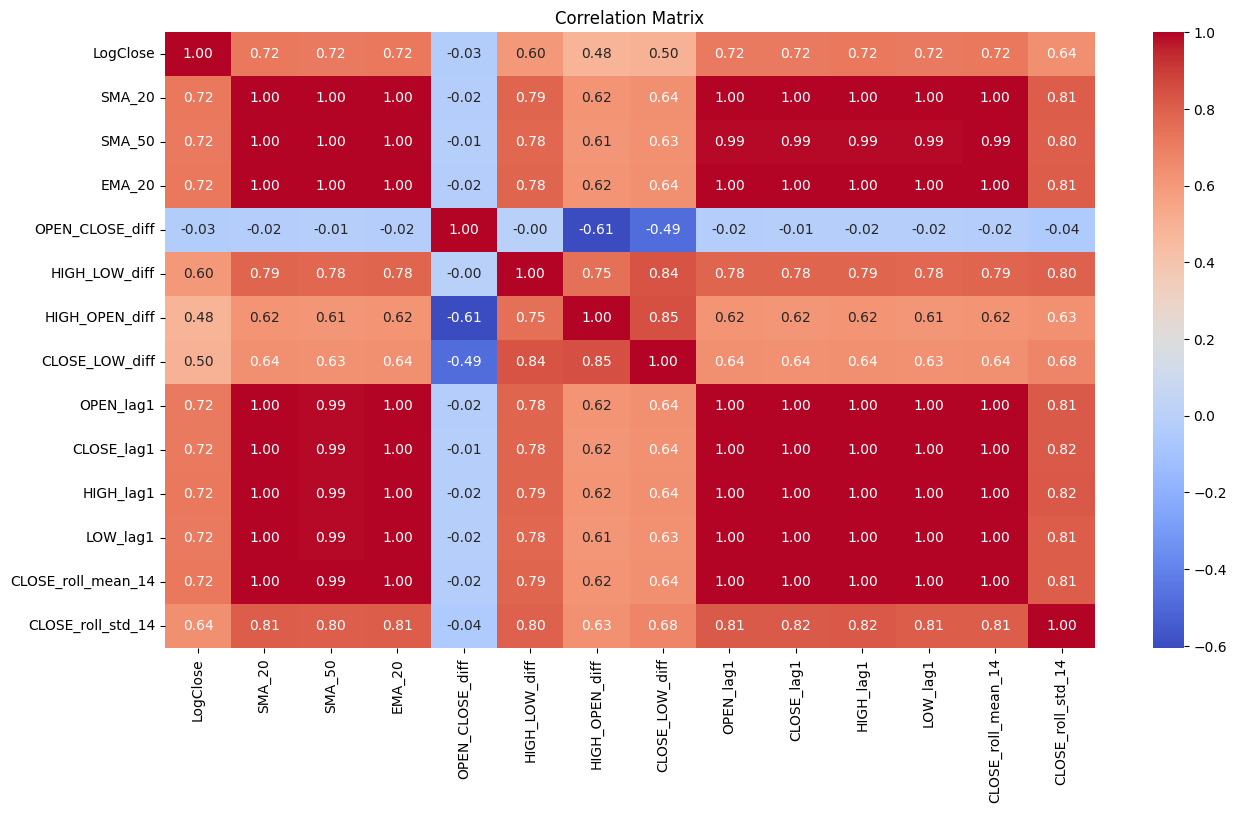

In [22]:
# Compute correlation matrix
correlation_matrix = cleaned_data[feature_cols].corr()

# Visualize correlation
plt.figure(figsize=(15, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# Data Splitting
## Train-Test Split and Scaling the data

In [23]:
train_frac=0.8
val_frac=0.1

total_samples = len(X_raw)
train_size = int(train_frac * total_samples)
val_size   = int(val_frac * total_samples)

# Train/Val/Test Split
X_train_raw = X_raw[:train_size]
y_train_raw = y_raw[:train_size]
dates_train = dates[:train_size]

X_val_raw   = X_raw[train_size:train_size + val_size]
y_val_raw   = y_raw[train_size:train_size + val_size]
dates_val   = dates[train_size:train_size + val_size]

X_test_raw  = X_raw[train_size + val_size:]
y_test_raw  = y_raw[train_size + val_size:]
dates_test  = dates[train_size + val_size:]

print(f"X_train_raw: {X_train_raw.shape}, X_val_raw: {X_val_raw.shape}, X_test_raw: {X_test_raw.shape}, y_train_raw: {y_train_raw.shape}, y_val_raw: {y_val_raw.shape}, y_test_raw: {y_test_raw.shape}")

scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Fit on TRAIN only for features (reshape to 2D for scaling)
X_train_2d = X_train_raw.reshape(-1, X_train_raw.shape[2])
scaler_X.fit(X_train_2d)

X_train_final = scaler_X.transform(X_train_2d).reshape(X_train_raw.shape)
X_val_final  = scaler_X.transform(X_val_raw.reshape(-1, X_val_raw.shape[2])).reshape(X_val_raw.shape)
X_test_final  = scaler_X.transform(X_test_raw.reshape(-1, X_test_raw.shape[2])).reshape(X_test_raw.shape)

# Scale target values if needed (not returned)
y_train_2d = y_train_raw.reshape(-1, 1)
scaler_y.fit(y_train_2d)
y_train_final = scaler_y.transform(y_train_2d).flatten()
y_val_final  = scaler_y.transform(y_val_raw.reshape(-1, 1)).flatten()
y_test_final  = scaler_y.transform(y_test_raw.reshape(-1, 1)).flatten()

print(f"X_train_scaled: {X_train_final.shape}, X_val_scaled: {X_val_final.shape}, X_test_scaled: {X_test_final.shape}, y_train_scaled: {y_train_final.shape}, y_val_scaled: {y_val_final.shape}, y_test_scaled: {y_test_final.shape}")


X_train_raw: (3936, 30, 14), X_val_raw: (492, 30, 14), X_test_raw: (493, 30, 14), y_train_raw: (3936,), y_val_raw: (492,), y_test_raw: (493,)
X_train_scaled: (3936, 30, 14), X_val_scaled: (492, 30, 14), X_test_scaled: (493, 30, 14), y_train_scaled: (3936,), y_val_scaled: (492,), y_test_scaled: (493,)


# Model Training

In [ ]:
l2_reg = tf.keras.regularizers.l2(1e-4)
dropout_rate = 0.3

# Determine window_size and number of features from X_train
window_size = X_train_final.shape[1]
num_features = X_train_final.shape[2]

model = Sequential([
    layers.Input(shape=(window_size, num_features)),
    layers.LSTM(
        64,
        return_sequences=True,
        kernel_regularizer=l2_reg,
        recurrent_regularizer=l2_reg,
        bias_regularizer=l2_reg
    ),
    layers.Dropout(dropout_rate),
    layers.LSTM(
        64,
        return_sequences=False,
        kernel_regularizer=l2_reg,
        recurrent_regularizer=l2_reg,
        bias_regularizer=l2_reg
    ),
    layers.Dropout(dropout_rate),
    layers.Dense(1)  # outputs scaled LogClose
])

optimizer = Adam(learning_rate=0.0005)
model.compile(loss='mse', optimizer=optimizer, metrics=['mean_absolute_error'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

history = model.fit(
    X_train_final,
    y_train_final,
    validation_data=(X_val_final, y_val_final),
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


2025-05-16 07:00:26.972741: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 19s 99ms/step - loss: 0.2389 - mean_absolute_error: 0.2996 - val_loss: 0.0382 - val_mean_absolute_error: 0.0341 - learning_rate: 5.0000e-04
Epoch 2/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - loss: 0.0545 - mean_absolute_error: 0.0965 - val_loss: 0.0354 - val_mean_absolute_error: 0.0254 - learning_rate: 5.0000e-04
Epoch 3/200
 85/123 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.0493 - mean_absolute_error: 0.0888

# Model Evaluation

In [ ]:
train_preds_scaled = model.predict(X_train_final).flatten()
val_preds_scaled = model.predict(X_val_final).flatten()
test_preds_scaled = model.predict(X_test_final).flatten()

train_preds_log = scaler_y.inverse_transform(train_preds_scaled.reshape(-1, 1)).flatten()
val_preds_log = scaler_y.inverse_transform(val_preds_scaled.reshape(-1, 1)).flatten()
test_preds_log = scaler_y.inverse_transform(test_preds_scaled.reshape(-1, 1)).flatten()

# Convert back from log scale
train_preds = np.expm1(train_preds_log)
val_preds = np.expm1(val_preds_log)
test_preds = np.expm1(test_preds_log)

y_train_log = scaler_y.inverse_transform(y_train_final.reshape(-1, 1)).flatten()
y_val_log = scaler_y.inverse_transform(y_val_final.reshape(-1, 1)).flatten()
y_test_log = scaler_y.inverse_transform(y_test_final.reshape(-1, 1)).flatten()

y_train_orig = np.expm1(y_train_log)
y_val_orig = np.expm1(y_val_log)
y_test_orig = np.expm1(y_test_log)

# ------------------------------------------------------
#  Evaluation
# ------------------------------------------------------
train_mse = mean_squared_error(y_train_orig, train_preds)
val_mse = mean_squared_error(y_val_orig, val_preds)
test_mse = mean_squared_error(y_test_orig, test_preds)

train_mae = mean_absolute_error(y_train_orig, train_preds)
val_mae = mean_absolute_error(y_val_orig, val_preds)
test_mae = mean_absolute_error(y_test_orig, test_preds)

train_r2 = r2_score(y_train_orig, train_preds)
val_r2 = r2_score(y_val_orig, val_preds)
test_r2 = r2_score(y_test_orig, test_preds)

logging.info("Training Metrics:")
logging.info(f" - MSE: {train_mse:.4f}")
logging.info(f" - MAE: {train_mae:.4f}")
logging.info(f" - R²:  {train_r2:.4f}")

logging.info("Validation Metrics:")
logging.info(f" - MSE: {val_mse:.4f}")
logging.info(f" - MAE: {val_mae:.4f}")
logging.info(f" - R²:  {val_r2:.4f}")

logging.info("Test Metrics:")
logging.info(f" - MSE: {test_mse:.4f}")
logging.info(f" - MAE: {test_mae:.4f}")
logging.info(f" - R²:  {test_r2:.4f}")

metrics = {
    "train": {
        "MSE": train_mse,
        "MAE": train_mae,
        "R-squared": train_r2
    },
    "validation": {
        "MSE": val_mse,
        "MAE": val_mae,
        "R-squared": val_r2
    },
    "test": {
        "MSE": test_mse,
        "MAE": test_mae,
        "R-squared": test_r2
    }
}
print(metrics)

In [ ]:
# Assuming 'history' is the History object returned from model.fit()
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs. Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Plot for Training Data: Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(dates_train, y_train_orig, label="Actual")
plt.plot(dates_train, train_preds, label="Predicted")
plt.title("Training Data: Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

# Plot for Validation Data: Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(dates_val, y_val_orig, label="Actual")
plt.plot(dates_val, val_preds, label="Predicted")
plt.title("Validation Data: Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

# Plot for Test Data: Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(dates_test, y_test_orig, label="Actual")
plt.plot(dates_test, test_preds, label="Predicted")
plt.title("Test Data: Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()
